# **Komande za download dataseta**

In [ ]:
! pip install kaggle

In [ ]:
!pip install keras-tuner -q

In [ ]:
!pip install torchvision 

In [ ]:
!pip install torch

In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download landlord/handwriting-recognition

In [ ]:
! unzip handwriting-recognition

# **NOVA**

## **Učitavanje biblioteka**

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

## **Učitavanje podataka**

In [7]:
train_img_path = 'train_v2/train/'
val_img_path = 'validation_v2/validation/'
test_img_path = 'test_v2/test'

In [8]:
train_csv = pd.read_csv('written_name_train_v2.csv')
val_csv = pd.read_csv('written_name_validation_v2.csv')
test_csv = pd.read_csv('written_name_test_v2.csv')

In [92]:
nove_csv = pd.read_csv('nove_slike.csv')

## **Čišćenje podataka**

### **Izbacivanje NA vrijednosti**

In [9]:
print("Number of NaNs in train set: ", train_csv['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set: ", val_csv['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set: ", test_csv['IDENTITY'].isnull().sum())

Number of NaNs in train set:  565
Number of NaNs in validation set:  78
Number of NaNs in validation set:  70


In [10]:
train_csv = train_csv.dropna()
val_csv = val_csv.dropna()
test_csv = test_csv.dropna()

### **Izbacivanje UNREADABLE vrijednosti**

In [11]:
print("Number od UNREADABLEs in train set: ", len(train_csv[train_csv['IDENTITY'] == 'UNREADABLE']))
print("Number od UNREADABLEs in validation set: ", len(val_csv[val_csv['IDENTITY'] == 'UNREADABLE']))
print("Number od UNREADABLEs in test set: ", len(test_csv[test_csv['IDENTITY'] == 'UNREADABLE']))

Number od UNREADABLEs in train set:  102
Number od UNREADABLEs in validation set:  12
Number od UNREADABLEs in test set:  11


In [12]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
val_csv = val_csv[val_csv['IDENTITY'] != 'UNREADABLE']
test_csv = test_csv[test_csv['IDENTITY'] != 'UNREADABLE']

### **Postavljanje svih slova na mala**

In [13]:
characters = set(char for label in train_csv['IDENTITY'].values for char in label)
len(characters)

50

In [14]:
#Za trening podatke
train_csv['IDENTITY'] = train_csv['IDENTITY'].str.lower()
train_csv.reset_index(inplace=True, drop=True)

#Za validacijske podatke
val_csv['IDENTITY'] = val_csv['IDENTITY'].str.lower()
val_csv.reset_index(inplace=True, drop=True)

#Za test podatke
test_csv['IDENTITY'] = test_csv['IDENTITY'].str.lower()
test_csv.reset_index(inplace=True, drop=True)

In [93]:
nove_csv['IDENTITY'] = nove_csv['IDENTITY'].str.lower()
nove_csv.reset_index(inplace=True, drop=True)

## **Preprocesiranje podataka**

### **One-hot enkodiranje labela**

In [ ]:
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#max_length = max([len(label) for label in train_csv['IDENTITY'].values]) #34

#tokenizer = Tokenizer(num_words = max_length, char_level = True)
#tokenizer.fit_on_texts(train_csv['IDENTITY'].values)
#word_index = tokenizer.word_index

In [ ]:
#sample_sequence = tokenizer.texts_to_sequences(['Vjestacka inteligencija'])
#sample_pad = pad_sequences(sample_sequence, maxlen = max_length, padding = 'post')
#sample_text = tokenizer.sequences_to_texts(sample_sequence)

In [ ]:
#print("Sample sequence: ", sample_sequence[0])
#print("Sample pad: ", sample_pad[0])
#print("Sample text: ", sample_text[0])

Sample sequence:  [19, 21, 1, 10, 8, 2, 12, 23, 2, 25, 3, 4, 8, 1, 5, 3, 16, 1, 4, 12, 3, 21, 2]
Sample text:  v j e s t a c k a   i n t e l i g e n c i j a


In [ ]:
#labels = train_csv['IDENTITY'].values

### **Funkcija za enkodiranje labela**

In [15]:
labels = train_csv['IDENTITY'].values

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max([len(label) for label in train_csv['IDENTITY'].values])
tokenizer = Tokenizer(num_words = max_length, char_level = True)
tokenizer.fit_on_texts(train_csv['IDENTITY'].values)

def preprocess_label(label):  
  label_sequence = tokenizer.texts_to_sequences([label])
  label = pad_sequences(label_sequence, maxlen=max_length, padding='post')[0]
  return label

### **Preprocesiranje slika**

In [17]:
images = train_csv['FILENAME'].values

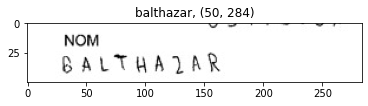

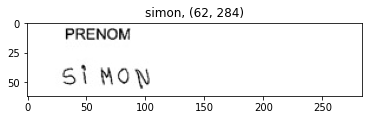

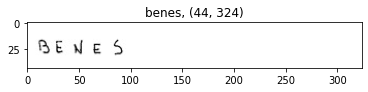

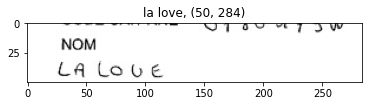

In [18]:
for i in range(4):
  img_path = 'train_v2/train/' + train_csv.loc[i, 'FILENAME']
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  plt.imshow(img, cmap='gray')
  title = train_csv.loc[i, 'IDENTITY']
  plt.title(f'{title}, {img.shape}')
  plt.show()

**Funkcija za postavljanje dimenzija slike (64x256)**

*   Budući da neuronske mreže primaju ulaze iste veličine, sve slike moraju biti promijenjene na fiksnu veličinu prije nego što postanu ulaz u CNN

In [19]:
def reshape(image):
  (h, w) = image.shape

  if h > 64:
    image = image[:64, :]

  if w > 256:
    image = image[:, :256]

  res = np.ones([64, 256])*255
  res[:h, :w] = image
  return res

**Funkcija za rotiranje slike za 90 stepeni**

In [20]:
def rotate(image):
  image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
  return image

**Funkcija za normalizaciju slike [0,1]**

*   Postavljanje vrijednosti piksela na intervalu [0,1]
*   Potrebna zbog povećanja dinamičkog raspona
*   Dovodi raspon vrijednosti intenziteta slike u normalnu distribuciju

In [21]:
def normalize(image):
  image = image/255.
  return image

### **Primjena funkcija za preprocesiranja na podatke**

In [22]:
train_len = 30000
val_len = 3000
test_len = 3000

**Preprocesiranje trening podataka**

In [23]:
train_X = [] #Ovdje ce biti slike za treniranje
train_Y = [] #Ovdje ce biti labele za treniranje tj. IDENTITY kolona iz train_csv
train_label_len = [] #Ovdje ce biti duzine labela

In [24]:
for i in range(train_len):
    img_dir = 'train_v2/train/'+train_csv.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = reshape(image)
    image = rotate(image)
    image = normalize(image)
    train_X.append(image)

    current_label = train_csv.loc[i, 'IDENTITY']
    train_label_len.append(len(current_label))
    current_label = preprocess_label(current_label)
    train_Y.append(current_label)

In [25]:
train_X = np.array(train_X)
train_Y = np.array(train_Y)
train_label_len = np.array(train_label_len)

**Preprocesiranje validacijskih podataka**

In [26]:
val_X = [] #Ovdje ce biti slike za validaciju
val_Y = [] #Ovdje ce biti labele za validaciju tj. IDENTITY kolona iz val_csv
val_label_len = [] #Ovdje ce biti duzine labela

In [27]:
for i in range(val_len):
    img_dir = 'validation_v2/validation/'+val_csv.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = reshape(image)
    image = rotate(image)
    image = normalize(image)
    val_X.append(image)

    current_label = val_csv.loc[i, 'IDENTITY']
    val_label_len.append(len(current_label))
    current_label = preprocess_label(current_label)
    val_Y.append(current_label)

In [28]:
val_X = np.array(val_X)
val_Y = np.array(val_Y)
val_label_len = np.array(val_label_len)

**Preprocesiranje testnih podataka**

In [29]:
test_X = [] 
test_Y = []
test_label_len = [] 

In [30]:
for i in range(test_len):
    img_dir = 'test_v2/test/'+test_csv.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = reshape(image)
    image = rotate(image)
    image = normalize(image)
    test_X.append(image)

    current_label = test_csv.loc[i, 'IDENTITY']
    test_label_len.append(len(current_label))
    current_label = preprocess_label(current_label)
    test_Y.append(current_label)

In [31]:
test_X = np.array(test_X)
test_Y = np.array(test_Y)
test_label_len = np.array(test_label_len)

In [94]:
nove_X = []
nove_Y = []
nove_label_len = []

nove_len = 50

for i in range(nove_len):
    img_dir = 'nove_slike/'+nove_csv.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = reshape(image)
    image = rotate(image)
    image = normalize(image)
    nove_X.append(image)

    current_label = nove_csv.loc[i, 'IDENTITY']
    nove_label_len.append(len(current_label))
    current_label = preprocess_label(current_label)
    nove_Y.append(current_label)

nove_X = np.array(nove_X)
nove_Y = np.array(nove_Y)
nove_label_len = np.array(nove_label_len)

## **Tuning hiperparametara**

In [ ]:
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout

def HyperModel(hp):
  pokusaj = keras.Sequential()

  pokusaj.add(Conv2D(
      filters=hp.Choice('num_filters_1', values=[16, 32, 64], default = 32),
      kernel_size=hp.Choice('kernel_1', values=[2,3,4,5], default=3),
      strides=hp.Choice('stride1', values=[1,2,3], default=1),
      activation = 'relu',
      input_shape = (256, 64, 1)))
  
  pokusaj.add(MaxPooling2D(pool_size=2))
  
  pokusaj.add(Conv2D(
      filters=hp.Choice('num_filters_2', values=[16, 32, 64], default = 32),
      kernel_size=hp.Choice('kernel_2', values=[2,3,4,5], default=3),
      strides=hp.Choice('stride2', values=[1,2,3], default=1),
      activation = 'relu'))
  
  pokusaj.add(MaxPooling2D(pool_size=2))

  pokusaj.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.3, step=0.1)))

  pokusaj.add(Dense(
      units=hp.Int('dense_units', min_value=32, max_value=512, step=32,default=128),
      activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
  
  pokusaj.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.5, step=0.1)))

  pokusaj.add(Dense(34, activation='softmax'))

  pokusaj.compile(
      optimizer = Adam(
          hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  
  return pokusaj

<ipython-input-35-6536ebef6daf>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [ ]:
import keras_tuner
p = HyperModel(keras_tuner.HyperParameters())
p.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 62, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 31, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 29, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 27776)             0

In [ ]:
tuner = Hyperband(
HyperModel,
max_epochs=12,
objective='val_accuracy',
executions_per_trial=3,
directory='hyperband',
project_name='hyperband_2')

In [ ]:
tuner.search(train_X, train_Y, epochs=2, validation_data=(val_X, val_Y))

In [ ]:
tuner.results_summary()

## **Izgradnja modela**

In [ ]:
#train_input_len = np.ones([train_len, 1]) * 48
#valid_input_len = np.ones([val_len, 1]) * 48
#valid_output = np.zeros([val_len])

### **Funkcija gubitka**

In [34]:
from keras import backend as K
def ctc_loss(args):
    labels, y_pred, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### **Ulazi modela**

In [ ]:
input_image = layers.Input(shape=(256, 64, 1), name='image')
labels = layers.Input(name='label', shape=(max_length))
input_length = layers.Input(name='input_length', shape=(1,))
label_length = layers.Input(name='label_length', shape=(1,))

### **Slojevi modela**

In [ ]:
x = layers.Conv2D(32, kernel_size=2, activation='relu', strides=1, padding='same', name='Conv1')(input_image)
x = layers.MaxPooling2D((2,2), name='Pool1')(x)

x = layers.Conv2D(64, kernel_size=2, activation='relu', strides=1, padding='same', name='Conv2')(x)
x = layers.MaxPooling2D((2,2), name='Pool2')(x)
x = layers.Dropout(0.2)(x)

x = layers.Reshape(target_shape=(64,1024), name="Reshape")(x)
x = layers.Dense(256, activation="relu", name="Dense1")(x)
x = layers.Dropout(0.3)(x)

x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)

y_pred = layers.Dense(34, activation="softmax", name="Output")(x)

### **Izlaz modela**

In [ ]:
loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([labels, y_pred, input_length, label_length])

### **Finalna inicijalizacija i pregled**

In [ ]:
model = keras.models.Model(inputs=[input_image, labels, input_length, label_length], outputs=loss_out)

In [ ]:
opt=keras.optimizers.Adam(learning_rate=0.003)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 64, 32)  160         ['image[0][0]']                  
                                                                                                  
 Pool1 (MaxPooling2D)           (None, 128, 32, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 128, 32, 64)  8256        ['Pool1[0][0]']              

## **Treniranje modela**

In [ ]:
history = model.fit(
    x = (train_X, train_Y, np.ones([train_len, 1]) * 48, train_label_len), 
    y = np.zeros([train_len]),
    validation_data = ([val_X, val_Y, np.ones([val_len, 1]) * 48, val_label_len], np.zeros([val_len]) ),
    epochs=40,
    batch_size = 128
)

Epoch 1/40
235/235 [==============================] - 56s 179ms/step - loss: 26.8815 - val_loss: 20.3114
Epoch 2/40
235/235 [==============================] - 38s 163ms/step - loss: 19.7922 - val_loss: 19.5509
Epoch 3/40
235/235 [==============================] - 39s 168ms/step - loss: 19.0194 - val_loss: 18.7000
Epoch 4/40
235/235 [==============================] - 38s 162ms/step - loss: 18.5107 - val_loss: 18.2756
Epoch 5/40
235/235 [==============================] - 39s 166ms/step - loss: 18.1469 - val_loss: 17.8155
Epoch 6/40
235/235 [==============================] - 38s 161ms/step - loss: 17.4954 - val_loss: 16.8036
Epoch 7/40
235/235 [==============================] - 39s 166ms/step - loss: 16.0633 - val_loss: 14.5365
Epoch 8/40
235/235 [==============================] - 38s 161ms/step - loss: 13.8874 - val_loss: 12.1740
Epoch 9/40
235/235 [==============================] - 38s 162ms/step - loss: 11.6608 - val_loss: 9.8189
Epoch 10/40
235/235 [==============================] - 3

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive

In [ ]:
import torch
import torchvision

In [ ]:
model_save_name = 'recognition.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model.save(path)

In [35]:
p = tf.keras.models.load_model(F'/content/gdrive/My Drive/recognition.pt', compile=False)

In [51]:
model=p

## **Validacija**

### **Pregled gubitka za trening i validacijske podatke**

In [39]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TypeError: ignored

## **Ostalo (za naredne faze...)**

In [41]:
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        decoded = tokenizer.sequences_to_texts([res.numpy()])
        output_text.append(decoded)
    return output_text

In [42]:
prediction_model = keras.models.Model(
    model.get_layer(name='image').input, model.get_layer(name='Output').output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 256, 64, 32)       160       
                                                                 
 Pool1 (MaxPooling2D)        (None, 128, 32, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 128, 32, 64)       8256      
                                                                 
 Pool2 (MaxPooling2D)        (None, 64, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 16, 64)        0         
                                                                 
 Reshape (Reshape)           (None, 64, 1024)          0     

In [43]:
preds = prediction_model.predict(val_X)
pred_texts = decode_predictions(preds)

94/94 [==============================] - 10s 17ms/step


In [44]:
pred_modified = []

for i in range(val_len):
  current = pred_texts[i][0]
  pom = ''
  for j in range(len(current)):
    if j % 2 == 0:
      pom += current[j]
  pred_modified.append(pom)

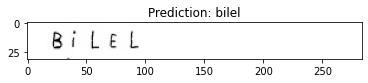

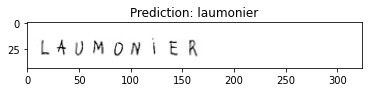

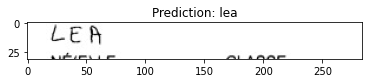

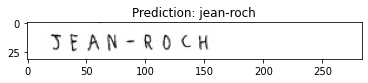

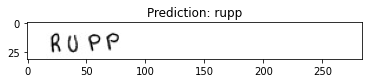

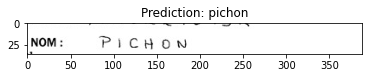

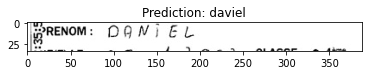

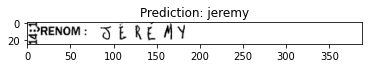

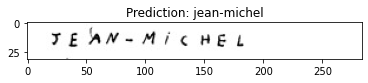

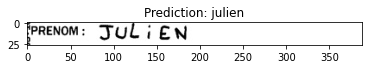

In [45]:
for i in range(10):
  img_path = 'validation_v2/validation/' + val_csv.loc[i, 'FILENAME']
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  plt.imshow(img, cmap='gray')
  title = val_csv.loc[i, 'IDENTITY']
  #plt.title(f'{title}, {img.shape}')
  plt.title(f"Prediction: {pred_modified[i]}")
  plt.show()

In [46]:
val_true = []

for i in range(val_len):
  val_true.append(val_csv['IDENTITY'].values[i])

In [ ]:
for i in range(35):
  true = val_true[i].upper()
  predicted = pred_modified[i].upper()
  s1 = 'ACTUAL: ' + true
  s2 = 'PREDICTED: ' + predicted
  print(f"{s1 : <20}{s2 : <50}")

ACTUAL: BILEL       PREDICTED: BILEL                                  
ACTUAL: LAUMIONIER  PREDICTED: LAUMONIER                              
ACTUAL: LEA         PREDICTED: LEA                                    
ACTUAL: JEAN-ROCH   PREDICTED: JEAN-ROCH                              
ACTUAL: RUPP        PREDICTED: RUPP                                   
ACTUAL: PICHON      PREDICTED: PICHON                                 
ACTUAL: DANIEL      PREDICTED: DAVIEL                                 
ACTUAL: JEREMY      PREDICTED: JEREMY                                 
ACTUAL: JEAN-MICHEL PREDICTED: JEAN-MICHEL                            
ACTUAL: JULIEN      PREDICTED: JULIEN                                 
ACTUAL: NAEL        PREDICTED: NAEL                                   
ACTUAL: BILGER      PREDICTED: BILGER                                 
ACTUAL: TIFFANY     PREDICTED: TIFFANY                                
ACTUAL: ELEEN       PREDICTED: ELEEN                                  
ACTUAL

In [47]:
def review_by_word(real, predicted):
  if real == predicted:
    return True
  return False

In [48]:
def correct_words(val_true, pred_modified):
  num_of_correct = 0
  l = len(val_true)
  for i in range(l):
    true = val_true[i]
    predicted = pred_modified[i]
    if(review_by_word(true, predicted)):
      num_of_correct += 1

  percentage = num_of_correct/l
  return percentage

In [49]:
def correct_characters(val_true, pred_modified):
  num_of_correct = 0
  num_of_total = 0
  l = len(val_true)
  for i in range(l):
    true_word = val_true[i]
    predicted_word = pred_modified[i]
    num_of_total += len(true_word)

    for j in range(min(len(true_word), len(predicted_word))):
      if true_word[j] == predicted_word[j]:
        num_of_correct += 1

  return num_of_correct/num_of_total

In [50]:
p = correct_words(val_true, pred_modified) * 100
c = correct_characters(val_true, pred_modified) * 100

print('Percentage of correct predicted words: ', p, '%')
print('Percentage of correct predicted characters: ', c, '%')

Percentage of correct predicted words:  71.66666666666667 %
Percentage of correct predicted characters:  90.08537452993191 %


## **Testiranje**

In [52]:
preds = prediction_model.predict(test_X)
pred_texts = decode_predictions(preds)

94/94 [==============================] - 2s 16ms/step


In [53]:
pred_modified = []

for i in range(val_len):
  current = pred_texts[i][0]
  pom = ''
  for j in range(len(current)):
    if j % 2 == 0:
      pom += current[j]
  pred_modified.append(pom)

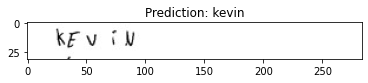

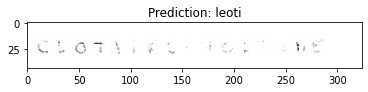

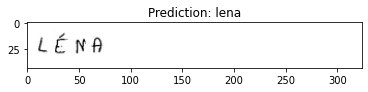

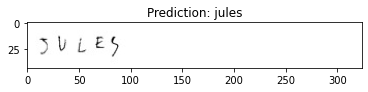

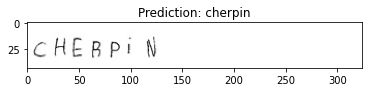

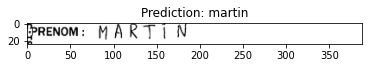

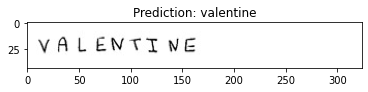

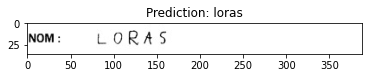

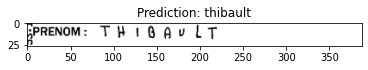

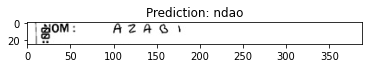

In [54]:
for i in range(10):
  img_path = 'test_v2/test/' + test_csv.loc[i, 'FILENAME']
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  plt.imshow(img, cmap='gray')
  title = val_csv.loc[i, 'IDENTITY']
  #plt.title(f'{title}, {img.shape}')
  plt.title(f"Prediction: {pred_modified[i]}")
  plt.show()

In [55]:
test_true = []

for i in range(test_len):
  test_true.append(test_csv['IDENTITY'].values[i])

In [ ]:
for i in range(25):
  true = test_true[i].upper()
  predicted = pred_modified[i].upper()
  s1 = 'ACTUAL: ' + true
  s2 = 'PREDICTED: ' + predicted
  print(f"{s1 : <20}{s2 : <50}")

ACTUAL: KEVIN       PREDICTED: KEVIN                                  
ACTUAL: CLOTAIRE    PREDICTED: LEOTI                                  
ACTUAL: LENA        PREDICTED: LENA                                   
ACTUAL: JULES       PREDICTED: JULES                                  
ACTUAL: CHERPIN     PREDICTED: CHERPIN                                
ACTUAL: MARTIN      PREDICTED: MARTIN                                 
ACTUAL: VALENTINE   PREDICTED: VALENTINE                              
ACTUAL: LORAS       PREDICTED: LORAS                                  
ACTUAL: THIBAULT    PREDICTED: THIBAULT                               
ACTUAL: AZABI       PREDICTED: NDAO                                   
ACTUAL: GORTCHAKOFF PREDICTED: GORTCHAREGEOTITX                       
ACTUAL: MAHENTHIRAN PREDICTED: MARENTHERAN                            
ACTUAL: FRANSOISSISEPHPREDICTED: FARANSSESSSIEADIATE                    
ACTUAL: JEANNE      PREDICTED: JEANNE                                 
ACTU

In [56]:
p = correct_words(test_true, pred_modified) * 100
c = correct_characters(test_true, pred_modified) * 100

print('Percentage of correct predicted words: ', p, '%')
print('Percentage of correct predicted characters: ', c, '%')

Percentage of correct predicted words:  70.89999999999999 %
Percentage of correct predicted characters:  89.52668166019218 %


## **Testiranje nad novim slikama**

In [95]:
preds = prediction_model.predict(nove_X)
pred_texts = decode_predictions(preds)

2/2 [==============================] - 0s 152ms/step


In [96]:
pred_modified = []

for i in range(nove_len):
  current = pred_texts[i][0]
  pom = ''
  for j in range(len(current)):
    if j % 2 == 0:
      pom += current[j]
  pred_modified.append(pom)

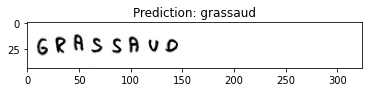

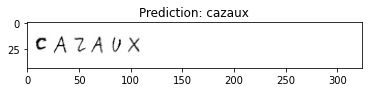

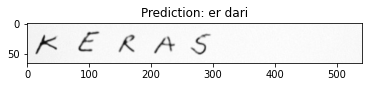

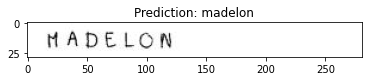

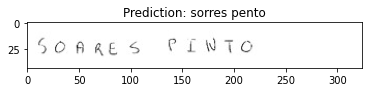

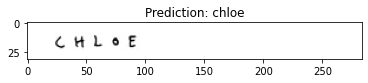

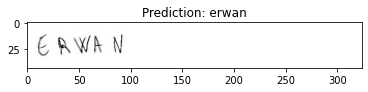

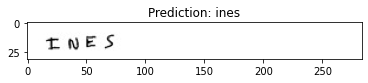

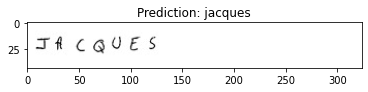

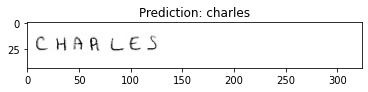

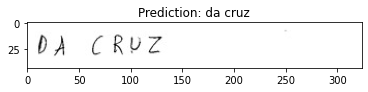

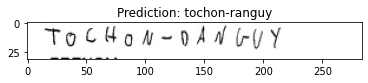

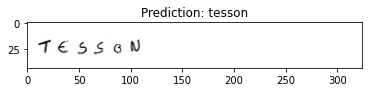

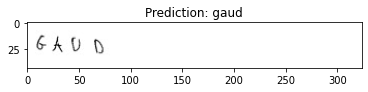

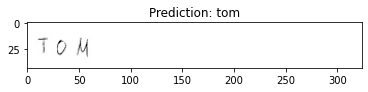

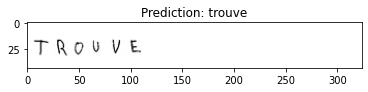

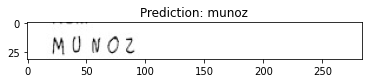

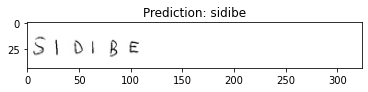

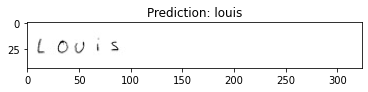

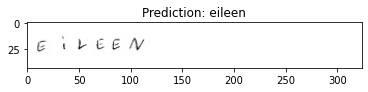

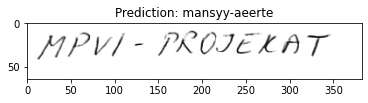

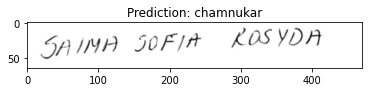

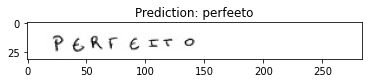

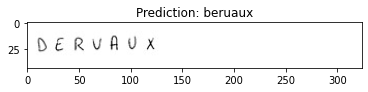

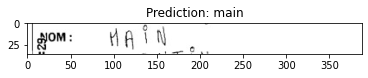

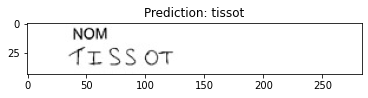

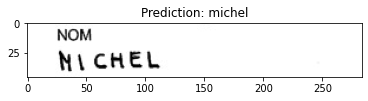

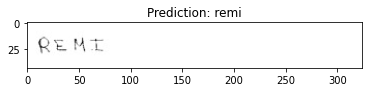

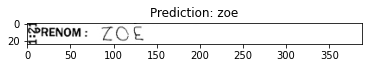

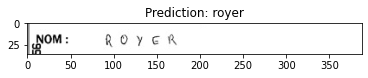

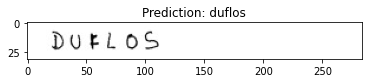

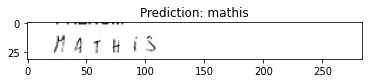

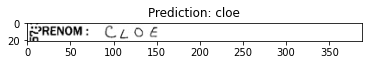

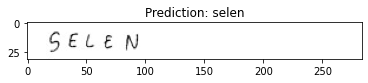

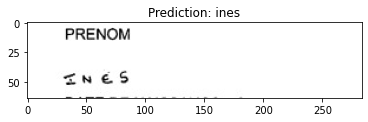

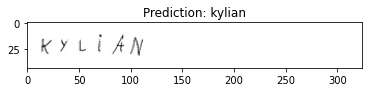

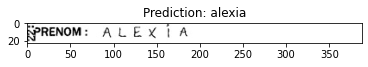

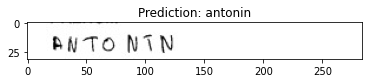

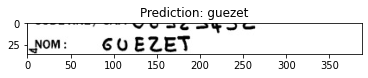

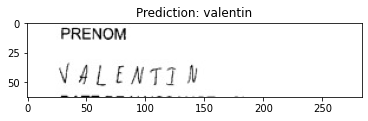

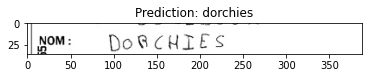

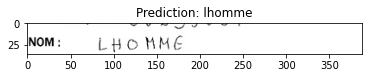

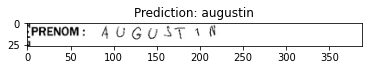

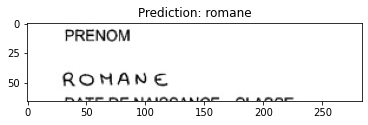

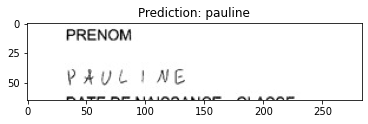

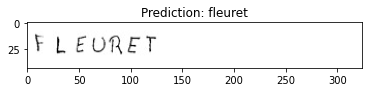

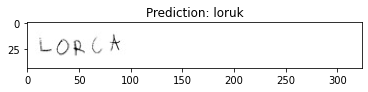

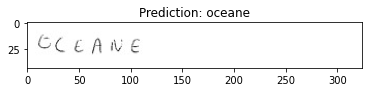

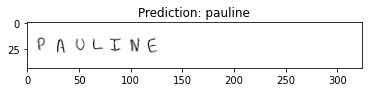

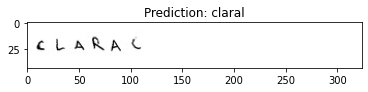

In [97]:
for i in range(nove_len):
  img_path = 'nove_slike/' + nove_csv.loc[i, 'FILENAME']
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  plt.imshow(img, cmap='gray')
  title = nove_csv.loc[i, 'IDENTITY']
  plt.title(f"Prediction: {pred_modified[i]}")
  plt.show()

In [98]:
nove_true = []

for i in range(nove_len):
  nove_true.append(nove_csv['IDENTITY'].values[i])

In [99]:
p = correct_words(nove_true, pred_modified) * 100
c = correct_characters(nove_true, pred_modified) * 100

print('Percentage of correct predicted words: ', p, '%')
print('Percentage of correct predicted characters: ', c, '%')

Percentage of correct predicted words:  82.0 %
Percentage of correct predicted characters:  87.38461538461539 %
